In [1]:
import py3Dmol

def show_mol(mol, view, grid):
    mb = Chem.MolToMolBlock(mol)
    view.removeAllModels(viewer=grid)
    view.addModel(mb,'sdf', viewer=grid)
    view.setStyle({'model':0},{'stick': {}}, viewer=grid)
    view.zoomTo(viewer=grid)
    return view

def view_single(mol):
    view = py3Dmol.view(width=480, height=480, linked=False, viewergrid=(1,1))
    show_mol(mol, view, grid=(0, 0))
    return view

### try to clean some of the data

reactants

In [2]:
import glob
import re

error_files = []

for xyz_file in sorted(glob.glob('data/gsm/reactants/*.xyz')):
    
    try:
        n = re.findall(r'\d+', xyz_file)[0]

        with open(xyz_file) as f:
            xyz = f.readlines()
        smiles = xyz[1]

        sdf_file = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
        with open(sdf_file) as f:
            sdf = f.readlines()
        sdf[0] = smiles

        with open(sdf_file, 'w') as f:
            f.writelines(sdf)
            
    except Exception as e:
        error_files.append(xyz_file)
        print(xyz_file, e)

fix errors

In [ ]:
error_file = error_files[7]
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)

In [ ]:
np.array(coords)

In [ ]:
m = Chem.MolFromSmiles(smi)
m = Chem.AddHs(m)
conformer = Chem.Conformer(len(syms))
m.AddConformer(conformer)
for i, a in enumerate(m.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    m.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))

In [ ]:
block = Chem.MolToMolBlock(m)
block = smi + block
print(block)

In [ ]:
view = py3Dmol.view(width=480, height=480, linked=False, viewergrid=(1,1))
show_mol(m, view, grid=(0, 0))

In [ ]:
n = re.findall(r'\d+', error_file)[0]
sdf_file = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
with open(sdf_file, 'w') as f:
    f.writelines(block)

products

In [79]:
from rdkit import Chem, Geometry
import numpy as np
import glob
import re

error_files = []

for xyz_file in sorted(glob.glob('data/gsm/products/*.xyz')):
    
    try:
        n = re.findall(r'\d+', xyz_file)[0]

        with open(xyz_file) as f:
            xyz = f.readlines()
        smiles = xyz[1]

        #skip multi products
        if '.' in smiles:
            continue

        sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
        with open(sdf_file) as f:
            sdf = f.readlines()
        sdf[0] = smiles

        if sdf[1] == '\n':
            del sdf[1]

        with open(sdf_file, 'w') as f:
            f.writelines(sdf)
            
    except Exception as e:
        error_files.append(xyz_file)
        print(xyz_file, e)

data/gsm/products/rxn011780products.xyz list index out of range
data/gsm/products/rxn012396products.xyz list index out of range
data/gsm/products/rxn012898products.xyz list index out of range
data/gsm/products/rxn014912products.xyz list index out of range
data/gsm/products/rxn016330products.xyz list index out of range
data/gsm/products/rxn016336products.xyz list index out of range
data/gsm/products/rxn016338products.xyz list index out of range
data/gsm/products/rxn016346products.xyz list index out of range
data/gsm/products/rxn016810products.xyz list index out of range
data/gsm/products/rxn016912products.xyz list index out of range
data/gsm/products/rxn018030products.xyz list index out of range
data/gsm/products/rxn018806products.xyz list index out of range
data/gsm/products/rxn019886products.xyz list index out of range
data/gsm/products/rxn019970products.xyz list index out of range
data/gsm/products/rxn020496products.xyz list index out of range
data/gsm/products/rxn021440products.xyz 

In [80]:
# for n=011780
error_file = 'data/gsm/products/rxn011780products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

view_single(r_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

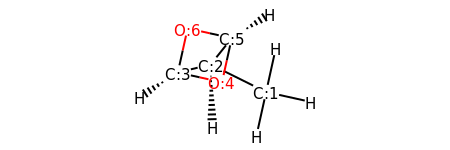

'[C:1]([C@@:2]1([H:10])[C@@:3]2([H:11])[O:4][C@:5]1([H:12])[O:6]2)([H:7])([H:8])[H:9]'

In [81]:
smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
display(smi_mol)
smi

In [83]:
# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# # breack C-Cs
# ep_mol.RemoveBond(0, 1)
# ep_mol.RemoveBond(1, 2)

# # C-C
# ep_mol.AddBond(0, 2, Chem.BondType.SINGLE)

view_single(ep_mol.GetMol())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [84]:
for b in p_mol.GetBonds():
    print(b.GetBeginAtom().GetSymbol(), b.GetBeginAtomIdx(), b.GetBondType(), b.GetEndAtom().GetSymbol(), b.GetEndAtomIdx())

C 0 SINGLE C 1
C 0 SINGLE H 6
C 0 SINGLE H 7
C 0 SINGLE H 8
C 1 SINGLE C 2
C 1 SINGLE C 4
C 1 SINGLE H 9
C 2 DOUBLE O 3
C 2 SINGLE H 10
C 4 DOUBLE O 5
C 4 SINGLE H 11


In [40]:
# for n=011302
error_file = 'data/gsm/products/rxn011302products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# breack C-Cs
ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 2)

# C-C
ep_mol.AddBond(0, 2, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [41]:
# for n=010420
error_file = 'data/gsm/products/rxn010524products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 13)
ep_mol.AddBond(2, 13, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(2, 5)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [42]:
# for n=010420
error_file = 'data/gsm/products/rxn010420products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycles!
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 4, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [43]:
# for n=010016
error_file = 'data/gsm/products/rxn010016products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# break C-C
ep_mol.RemoveBond(2, 1)

# H transfer
ep_mol.RemoveBond(1, 7)
ep_mol.AddBond(2, 7, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [44]:
# for n=009522
error_file = 'data/gsm/products/rxn009522products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycles!
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(2, 4, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [45]:
# for n=009414
error_file = 'data/gsm/products/rxn009414products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)

# H transfer
ep_mol.RemoveBond(0, 7)
ep_mol.AddBond(3, 7, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(0, 3, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [46]:
# for n=009348
error_file = 'data/gsm/products/rxn009348products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# C-O
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 3, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(3, 5)

# C=C
ep_mol.RemoveBond(5, 1)
ep_mol.AddBond(5, 1, Chem.BondType.DOUBLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [47]:
# for n=008488
error_file = 'data/gsm/products/rxn008488products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# break O-C
ep_mol.RemoveBond(3, 4)

# # H transfer
ep_mol.RemoveBond(3, 11)
ep_mol.AddBond(4, 11, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [48]:
# for n=007918
error_file = 'data/gsm/products/rxn007918products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single
ep_mol.RemoveBond(3, 4)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)

# H tranfser
ep_mol.RemoveBond(1, 10)
ep_mol.AddBond(4, 10, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(1, 4, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [49]:
# for n=007754
error_file = 'data/gsm/products/rxn007754products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(3, 9)
ep_mol.AddBond(5, 9, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(3, 5)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [50]:
# for n=007186
error_file = 'data/gsm/products/rxn007186products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# break C-O
ep_mol.RemoveBond(2, 3)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(3, 10, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [51]:
# for n=006410
error_file = 'data/gsm/products/rxn006410products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# ring!
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [52]:
# for n=006198
error_file = 'data/gsm/products/rxn006198products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(1, 10, Chem.BondType.SINGLE)

# # break C-C
ep_mol.RemoveBond(1, 2)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [53]:
# for n=005806
error_file = 'data/gsm/products/rxn005806products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)
smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 15)
ep_mol.AddBond(4, 15, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(4, 5)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [54]:
# for n=005670
error_file = 'data/gsm/products/rxn005670products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)
smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)

# H transfer
ep_mol.RemoveBond(0, 5)
ep_mol.AddBond(3, 5, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(3, 0, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [55]:
# for n=005484
error_file = 'data/gsm/products/rxn005484products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]
smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H shift
ep_mol.RemoveBond(1, 8)
ep_mol.AddBond(5, 8, Chem.BondType.SINGLE)

# remove C-C
ep_mol.RemoveBond(1, 5)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [56]:
# for n=005434
error_file = 'data/gsm/products/rxn005434products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)
# smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
# display(smi_mol)
# smi

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# # H transfer
ep_mol.RemoveBond(5, 10)
ep_mol.AddBond(3, 10, Chem.BondType.SINGLE)

# break N-C
ep_mol.RemoveBond(3, 5)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [57]:
# for n=005432
error_file = 'data/gsm/products/rxn005432products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)
# smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
# display(smi_mol)
# smi

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(1, 7)
ep_mol.AddBond(2, 7, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(2, 1)

# view_single(ep_mol.GetMol())
# for b in p_mol.GetBonds():
#     print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType())

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [58]:
# for n=003650
error_file = 'data/gsm/products/rxn003650products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)
# smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
# display(smi_mol)
# smi

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single C-C
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(5, 10, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)

# view_single(ep_mol.GetMol())
# for b in p_mol.GetBonds():
#     print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType())

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [59]:
# for n=002820
error_file = 'data/gsm/products/rxn002820products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)
# smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
# display(smi_mol)
# smi

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# double to single C-O
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

# add additional C-O
ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(4, 2, Chem.BondType.SINGLE)

# view_single(ep_mol.GetMol())
# for b in p_mol.GetBonds():
#     print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType())

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [60]:
# for n=001486
error_file = 'data/gsm/products/rxn001486products.xyz'
with open(error_file) as f:
    xyz = f.readlines()
    
smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]
view_single(r_mol)

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
# display(smi_mol)
# smi

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to double C=N
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.DOUBLE)

# double to single C-O
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)

# # add C-N
ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)

# # add C-O
ep_mol.AddBond(4, 0, Chem.BondType.SINGLE)

# view_single(ep_mol.GetMol())
# for b in p_mol.GetBonds():
#     print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType())

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [61]:
# for n=001334
error_file = 'data/gsm/products/rxn001334products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# view_single(r_mol)

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
# display(smi_mol)

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# replace triple bond wih single
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

# wrong hydrogen bond
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(5, 10, Chem.BondType.SINGLE)

# C-C bond
ep_mol.AddBond(5, 2, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [62]:
# for n=001226
error_file = 'data/gsm/products/rxn001226products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(0, 6)
ep_mol.AddBond(1, 6, Chem.BondType.SINGLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [63]:
# for n=000282
error_file = 'data/gsm/products/rxn000282products.xyz'
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)
syms_coords

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# single bond to oxygen
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)

# correct O-H bond
ep_mol.RemoveBond(5, 9)
ep_mol.AddBond(0, 9, Chem.BondType.SINGLE)

# C=C double bonds
ep_mol.RemoveBond(1, 5)
ep_mol.AddBond(1, 5, Chem.BondType.DOUBLE)

# write to file
block = Chem.MolToMolBlock(ep_mol.GetMol())
block = block.split('\n')
block[0] = smi

sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
with open(sdf_file, 'w') as f:
    f.writelines('\n'.join(block))

In [36]:
r_mols = []
for r_sdf in sorted(glob.glob('data/gsm/reactants_sdf/*.sdf')):
    r_mol = Chem.SDMolSupplier(r_sdf, removeHs=False)[0]
    r_mol.UpdatePropertyCache()
    r_mols.append(r_mol)
    
p_mols = []
for p_sdf in sorted(glob.glob('data/gsm/products_sdf/*.sdf')):
    p_mol = Chem.SDMolSupplier(p_sdf, removeHs=False)[0]
    p_mol.UpdatePropertyCache()
    p_mols.append(p_mol)

OSError: File error: Invalid input file data/gsm/products_sdf/rxn000938products.sdf

In [37]:
p_sdf

'data/gsm/products_sdf/rxn000938products.sdf'